In [61]:
%matplotlib notebook

# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx
from IPython.display import HTML
from matplotlib import animation
import networkx as nx

# Setup

## Parameters

In [62]:
plotIter=1000
nnodes=150
p_link=.05
leak=.25 #
leaktype=1 #1 = leak a percentage, or 2 = leak a constant rate
lrate_wmat=.1
lrate_targ=.01
targ_min=1.0
sens_offset=20
movement_amp=1
input_amp=5
spike_cost=0

## Plotting

## Set up sensor nodes and input connections

In [63]:
sensory_nodes=[]
input_wmat=np.zeros((2,nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,input_amp], weights=(1-p_link,p_link), k=1)[0]
        if input_wmat[row,col] > 0:
            sensory_nodes.append(col)
        
#select two random nodes to be output nodes
output_nodes = random.sample(range(1, nnodes), 2)
while (output_nodes[0] in sensory_nodes) or (output_nodes[1] in sensory_nodes):
    output_nodes = random.sample(range(1, nnodes), 2)

np.unique(sensory_nodes)
#output_nodes

array([  1,   2,   8,  14,  20,  38,  74,  87, 108, 118, 122, 139, 140,
       144])

In [64]:
output_nodes

[142, 110]

## Set up internal weight matrix

In [65]:
link_mat = np.zeros((nnodes,nnodes))
for row in range(link_mat.shape[0]):
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
# link_mat[:,:]=1
# np.fill_diagonal(link_mat,0)
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] = np.random.normal(0,1)
            
start_wmat=wmat.copy()

In [66]:
net = nx.from_numpy_matrix(wmat)
#nx.draw_networkx(net, arrows=True,width=.1,with_labels=False, node_size=5, pos = nx.shell_layout(net))
layout = nx.spring_layout(net)

## Functions

In [67]:
def get_plot_vals(degree, heading):
    x = np.cos(np.radians(degree))
    y = np.sin(np.radians(degree))
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    sLx = .5*np.cos(np.radians(sLdeg)) 
    sLy = .5*np.sin(np.radians(sLdeg)) 
    sLpos = np.array([sLx,sLy])
    
    sRx = .5*np.cos(np.radians(sRdeg)) 
    sRy = .5*np.sin(np.radians(sRdeg))
    sRpos = np.array([sRx, sRy])
    
    return x, y, sLx, sLy, sRx, sRy

def move_stim(degree):
    degree += 5
    if degree > 360:
        degree = degree - 360
    if degree < 0:
        degree = degree + 360

    return degree

def rotate_agent(output_acts, output_spikes, heading):
    diff = (output_acts[0] - output_acts[1])*movement_amp
    #diff = (output_spikes[0] - output_spikes[1])*movement_amp
    heading = heading + diff
    
    if heading > 360:
        heading = heading - 360
    if heading < 0:
        heading = heading + 360
    
    return heading

def get_input_acts(heading, degree):
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
        
    dL = np.abs(degree - sLdeg)
    if dL > 180:
        dL = 360 - dL
        
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    dR = np.abs(degree - sRdeg)
    if dR > 180:
        dR = 360 - dR
    
    if dL <= 60:
        sL_act = 1 - dL/60
    else:
        sL_act = 0
    
    if dR <= 60:
        sR_act = 1 - dR/60
    else:
        sR_act = 0
        
    return [sL_act, sR_act], [dL, dR]

def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets,spike_rep):
    if leaktype == 1:
        acts = acts*(1-leak) + np.dot(input, input_wmat) + np.dot(spikes, wmat)
    else:
        acts = acts-leak + np.dot(input, input_wmat) + np.dot(spikes, wmat)
        
    #acts[acts<0]=0
    
    thresholds = targets*2
    #CAN I MAKE NEURONS SPIKE MORE THAN ONCE IN THE TIME FRAME, eg spikes = np.floor(acts/thresholds) 
    #spikes = np.floor(acts/thresholds)
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    spike_rep[spikes==0]=0
    spike_rep[spikes==1]+=1
    
    spikes[spikes==1] = spikes[spikes==1]-(spike_rep[spikes==1] - 1)*spike_cost
    spikes[spikes<0]=0
    
    acts[spikes==1]=acts[spikes==1]-thresholds[spikes==1] #(1-(spike_cost*spike_rep[spikes==1]/1))
    #acts = acts - thresholds*spikes
       
    errors=acts-targets
    
    output_acts = acts[output_nodes]
    output_spikes = spikes[output_nodes]
    
    return acts, spikes, errors, output_acts, output_spikes,spike_rep

def learning(learn_on,link_mat,spikes, prev_spikes, errors,wmat,targets):
    prev_active= np.argwhere(prev_spikes > 0)[:,0]
    prev_inactive = np.argwhere(prev_spikes<=0)[:,0]
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_inactive,:]=0
    active_neighbors=np.sum(active_neighbors,axis=0)#+np.repeat(1,nnodes)
    
    if learn_on==1:
        if np.sum(active_neighbors) >0:
            errors_tmp = errors#/active_neighbors
            errors_tmp=errors_tmp/active_neighbors
            errors_tmp = np.nan_to_num(errors_tmp, posinf=0.0, neginf=0.0)
        
            d_wmat = np.zeros((nnodes,nnodes))
            d_wmat[:,:]=errors_tmp*lrate_wmat
            d_wmat[link_mat==0]=0
            d_wmat[prev_inactive,:]=0
            #d_wmat=(d_wmat/active_neighbors)
            #d_wmat=np.nan_to_num(d_wmat)
            wmat-=d_wmat

        #targets += errors_tmp*lrate_targ
        targets += errors * lrate_targ
        targets[targets<targ_min]=targ_min
        
    return wmat, targets



# Run the model

<IPython.core.display.Javascript object>


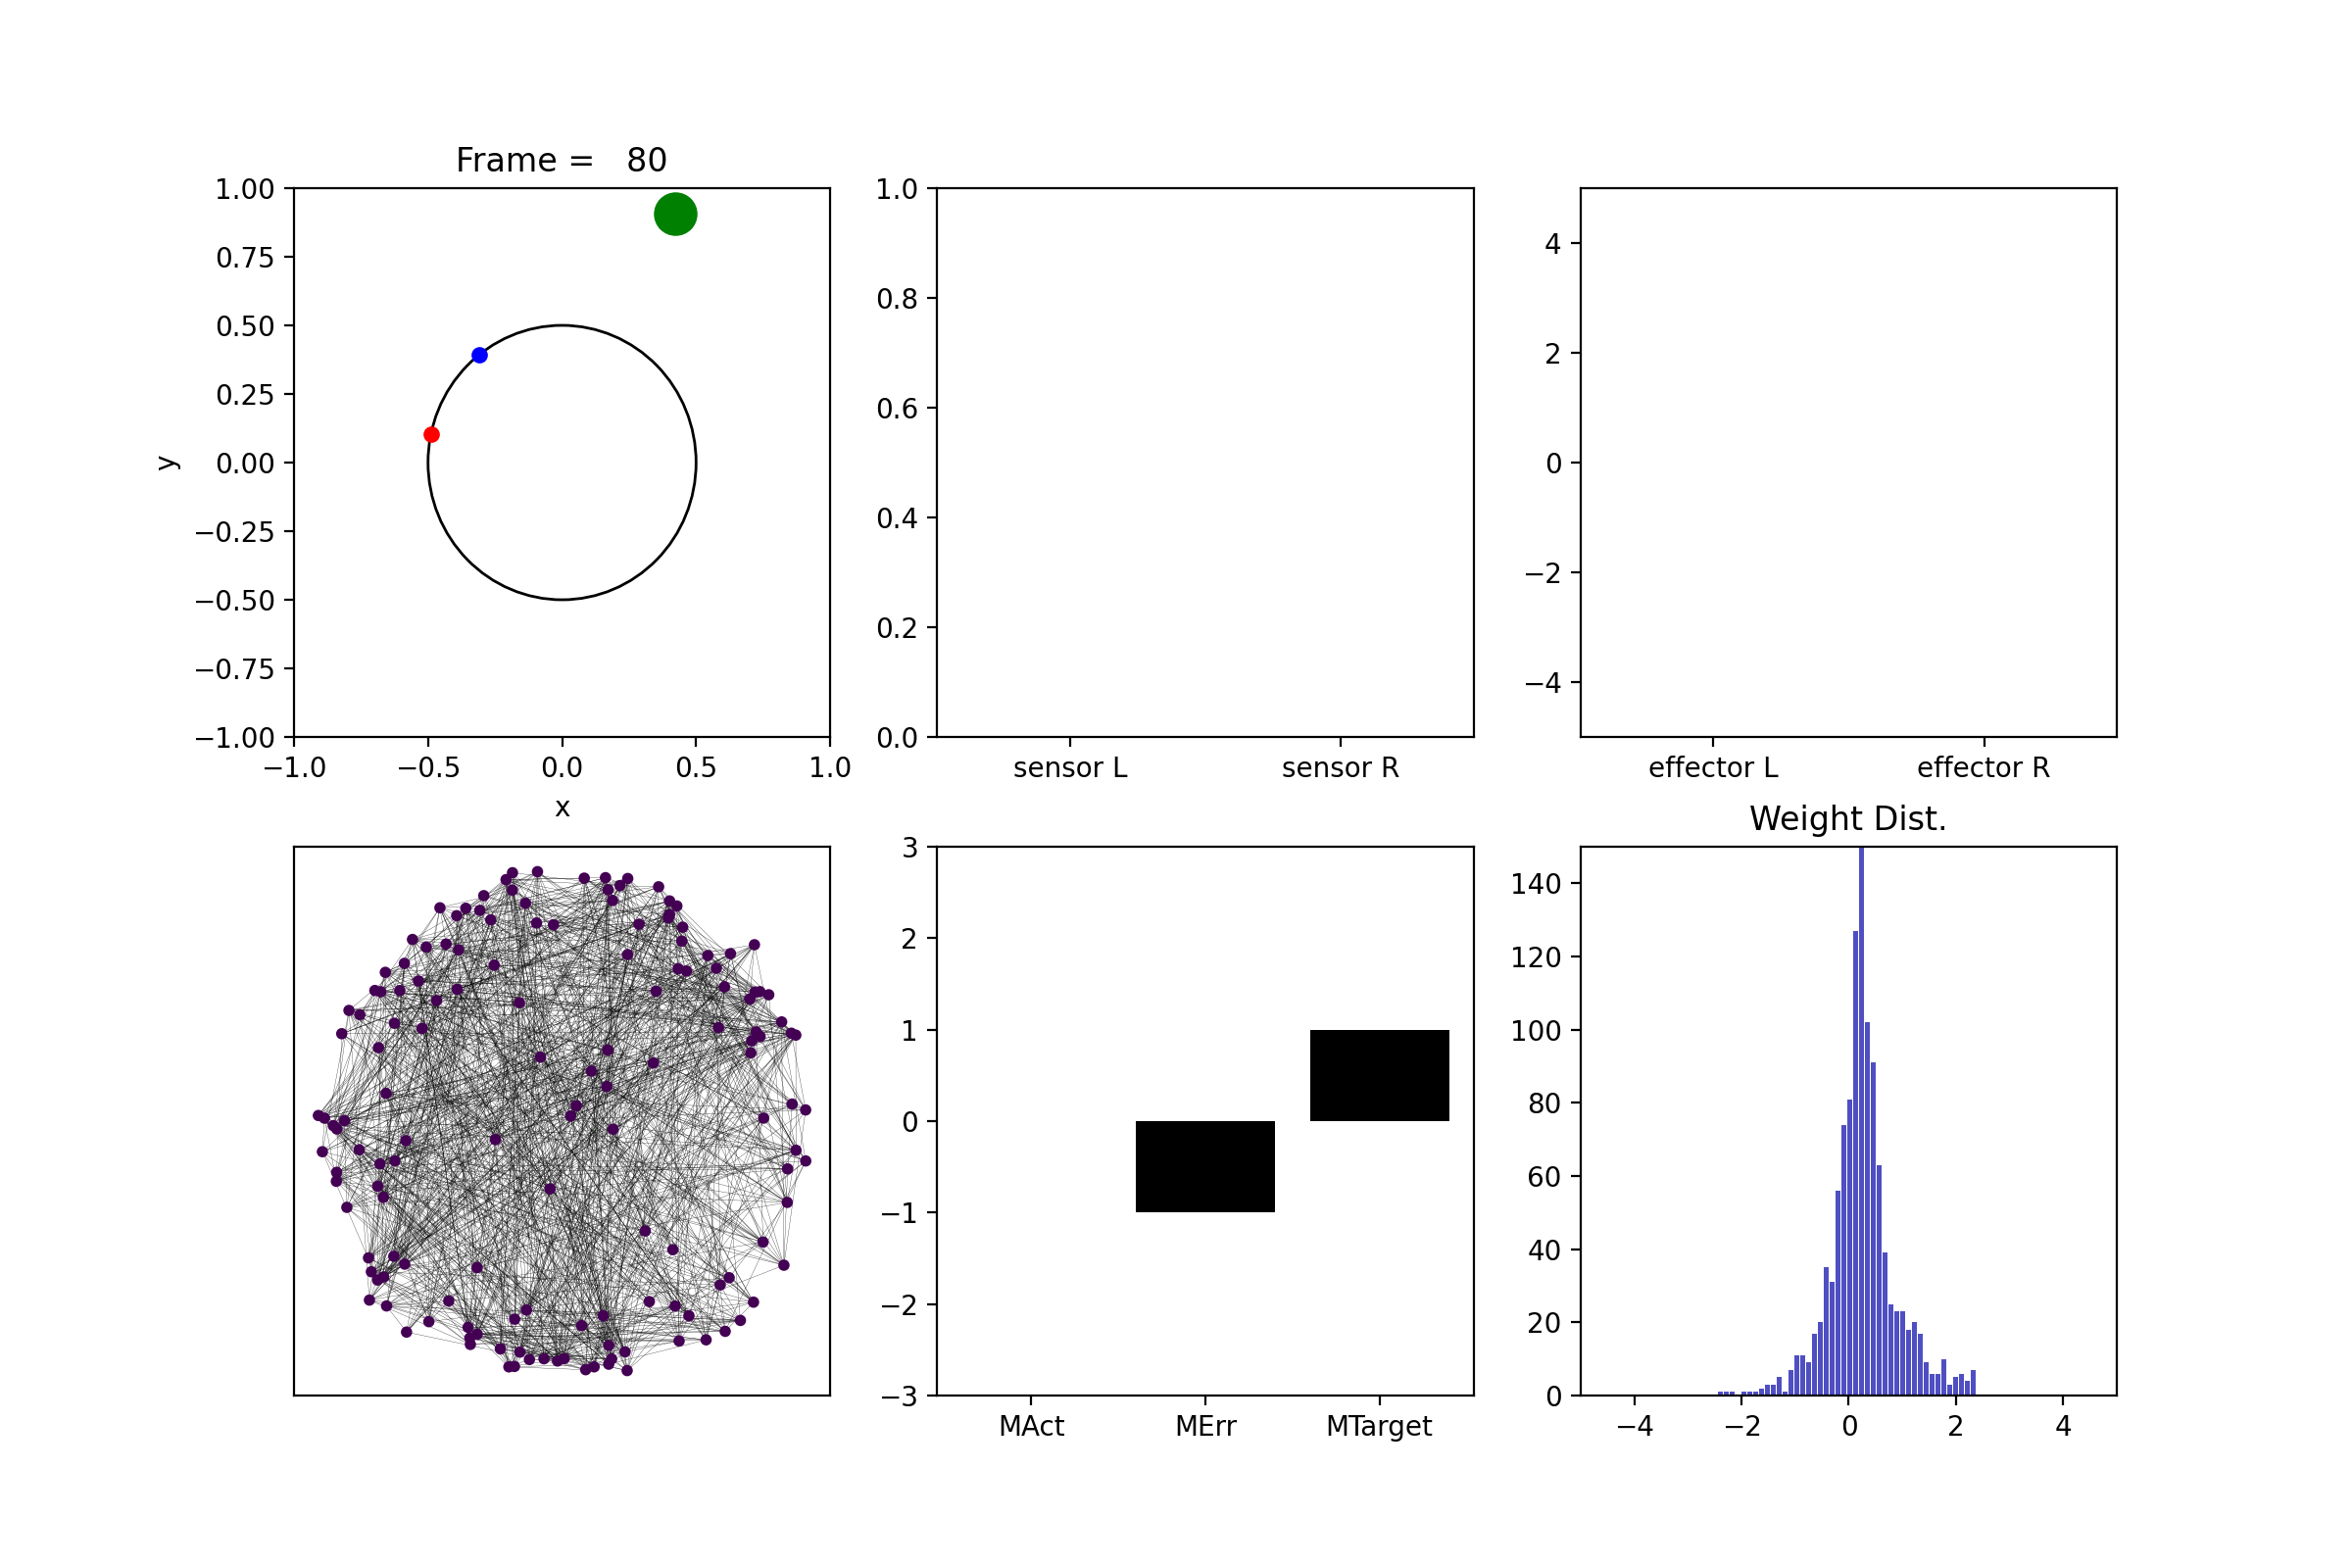

In [68]:
spikes=np.zeros(nnodes)
spike_rep=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
input_acts = np.zeros(2)
output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanAbsErs=[]
MeanActs =[]

i=1
degree = 0
heading = 180
learn_on=1
def drawframe(n):
    global degree, heading, acts, input_acts, output_acts, output_spikes,leak, spikes, prev_spikes, spike_rep, spike_cost, wmat, input_wmat, output_wmat, targets, errors,MeanAbsErs,MeanActs,MeanSpikes
    
    input, dists = get_input_acts(heading, degree)
        
    prev_spikes = spikes.copy()
    
    acts, spikes, errors, output_acts, output_spikes,spike_rep = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets,spike_rep)
        
    wmat, targets = learning(learn_on,link_mat,spikes, prev_spikes, errors, wmat,targets)
    
    x, y, sLx, sLy, sRx, sRy = get_plot_vals(degree, heading)
    
    degree = move_stim(degree)
    heading = rotate_agent(output_acts, output_spikes,heading)
    
    pt1.set_data(x,y)
    sL.set_data(sLx,sLy)
    sR.set_data(sRx,sRy)
    ax4.clear()
    netfig=nx.draw_networkx(net,width=.1,with_labels=False, node_size=10, pos = layout, node_color=spikes)
    bar1_plt2.set_height(input[0])
    bar2_plt2.set_height(input[1])
    bar1_plt3.set_height(output_acts[0])
    bar2_plt3.set_height(output_acts[1])
    bar1_plt5.set_height(np.mean(acts))
    #bar2_plt5.set_height(np.mean(np.abs(errors)))
    bar2_plt5.set_height(np.mean(errors))
    bar3_plt5.set_height(np.mean(targets))
    ax6.clear()
    ax6.set_ylim((0,150))
    ax6.set_xlim((-5,5))
    ax6.hist(x=np.matrix.flatten(wmat[link_mat==1]), bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
    txt_title1.set_text('Frame = {0:4d}'.format(n))
    txt_title6 = ax6.set_title('Weight Dist.')
    
    if (n % 100 !=0):
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        #print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
    else:
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        
        MeanAbsErs_ = np.mean(MeanAbsErs)
        MeanActs_ = np.mean(MeanActs)
        MeanSpikes_ = np.mean(MeanSpikes)
        print('iteration: ', str(n), ' ; MeanAbsErs: ',str(MeanAbsErs_), ' ; MeanAct: ', str(MeanActs_), '; MeanSpikes: ', str(MeanSpikes_))
        MeanAbsErs=[]
        MeanActs=[]
        MeanSpikes=[]
    
    #txt_title2.set_text('MnAbsEr: ' + str(np.mean(np.abs(errors))) + ' ; MnAct: ' + str(np.mean(acts)) + '; MnSpk: ', str(np.mean(spikes)))
    #txt_title2.set_text('MnAbsEr = {0:4d}'.format(np.mean(np.abs(errors))))
    #txt_title2.set_text('iteration: ' + str(n))
    return (pt1,sL,sR)

# create a figure and axes
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

# set up the subplots as needed
ax1.set_xlim(( -1, 1))            
ax1.set_ylim((-1, 1))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.sca(ax4)
netfig = nx.draw_networkx(net,width=.1,with_labels=False, node_size=10, pos = layout, node_color=spikes)

ax2.set_ylim((0, 1))
ax3.set_ylim((-5, 5))
ax5.set_ylim((-3,3))
ax6.set_ylim((0,150))
ax6.set_xlim((-5,5))

circle1 = plt.Circle((0, 0), 0.5, color='black', fill = 0)
ax1.add_patch(circle1)

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title1 = ax1.set_title('')
txt_title2 = ax2.set_title('')
txt_title6 = ax6.set_title('Weight Dist.')
pt1, = ax1.plot([], [], 'g.', ms=30)
sL, = ax1.plot([],[], 'r.', ms =10)
sR, = ax1.plot([],[], 'b.', ms =10)
bar1_plt2, bar2_plt2 = ax2.bar(['sensor L', 'sensor R'],[0,0], color = ['r','b'])
bar1_plt3, bar2_plt3 = ax3.bar(['effector L', 'effector R'],[0,0], color = ['r','b'])
bar1_plt5, bar2_plt5, bar3_plt5 = ax5.bar(['MAct','MErr', 'MTarget'],[0,0,0],color = 'black')
ax6.hist(x=np.matrix.flatten(wmat[link_mat==1]), bins='auto', color='black',alpha=0.7, rwidth=0.85)


spikes=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
input_acts = np.zeros(2)
output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanAbsErs=[]
MeanActs =[]
MeanSpikes = []

In [70]:
anim = animation.FuncAnimation(fig, drawframe, frames=plotIter, interval=20, blit=True)
#plt.show()

In [71]:
anim.save('MV_RotatingAgent2-60degFOV_posNeg_X.mp4') #v2

iteration:  0  ; MeanAbsErs:  1.0  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  0  ; MeanAbsErs:  1.0  ; MeanAct:  0.0 ; MeanSpikes:  0.0


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide


iteration:  100  ; MeanAbsErs:  0.953663315644205  ; MeanAct:  0.12344142531520368 ; MeanSpikes:  0.03646666666666667
iteration:  200  ; MeanAbsErs:  0.8194405087683699  ; MeanAct:  0.37474675721121664 ; MeanSpikes:  0.09946666666666665
iteration:  300  ; MeanAbsErs:  0.8645278082598905  ; MeanAct:  0.27453873927336764 ; MeanSpikes:  0.08193333333333333
iteration:  400  ; MeanAbsErs:  0.8017318706769551  ; MeanAct:  0.3948800715388407 ; MeanSpikes:  0.12380000000000001
iteration:  500  ; MeanAbsErs:  0.7975352306535409  ; MeanAct:  0.3846682736272633 ; MeanSpikes:  0.11553333333333335
iteration:  600  ; MeanAbsErs:  0.8244625362130713  ; MeanAct:  0.3183428861914585 ; MeanSpikes:  0.1048
iteration:  700  ; MeanAbsErs:  0.7151412276323001  ; MeanAct:  0.5174675286226716 ; MeanSpikes:  0.1709333333333333
iteration:  800  ; MeanAbsErs:  0.8356417565762804  ; MeanAct:  0.2941862554572845 ; MeanSpikes:  0.1052
iteration:  900  ; MeanAbsErs:  0.7483509322182005  ; MeanAct:  0.436623099320273

In [48]:
### alternate way to plot

iteration:  0  ; MeanAbsErs:  1.0  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  0  ; MeanAbsErs:  1.0  ; MeanAct:  0.0 ; MeanSpikes:  0.0


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide


iteration:  100  ; MeanAbsErs:  0.9132441117383736  ; MeanAct:  0.24829931332700503 ; MeanSpikes:  0.051


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x432', '-pix_fmt', 'rgba', '-r', '50.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/_6/4jczzt_n7rzgvcv0_ztm_g180000gn/T/tmp3t5td4ki/temp.m4v']' returned non-zero exit status 255.

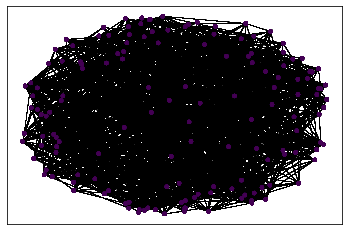

In [15]:
HTML(anim.to_html5_video())

In [ ]:
# hist of wmat
n, bins, patches = plt.hist(x=np.matrix.flatten(wmat), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Weights at End')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# hist of wmat
n, bins, patches = plt.hist(x=targets, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Targets at End')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)